In [5]:
import tensorflow as tf
from tensorflow import math
from tensorflow import keras
from keras import optimizers, metrics
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D, Reshape
from keras.callbacks import ModelCheckpoint
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import sys
import os

import csv


In [6]:
# set some parameters
num_classes = 2
epochs = 25
batch_size = 4


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


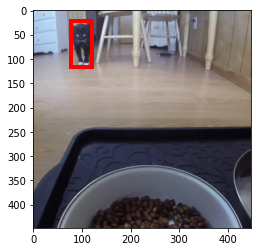

In [7]:
# for accessing drive
from google.colab import drive
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/Colab Notebooks/ECE 4424/Project/'

pet1_path = project_path + 'pet1'

pet1_csv = project_path + 'pet1.csv'

sys.path.append(pet1_path)

# get a list of files for the images
cat1_files = sorted([os.path.join(pet1_path, file)
                          for file in os.listdir(pet1_path)
                          if file.endswith('.png')])

# Load the datasets

ann_pet1 = list(csv.reader(open(pet1_csv))) 

ann_pet1 = list(zip(*ann_pet1)) 

cat1_files = ann_pet1[5][:]

im_num = 1
# display one of the images
im = plt.imread(pet1_path + '/'+cat1_files[im_num])
plt.imshow(im)

# apply the bounding box for the image
plt.gca().add_patch(Rectangle((int(ann_pet1[1][im_num]) , int(ann_pet1[2][im_num]) ), int(ann_pet1[3][im_num]), int(ann_pet1[4][im_num]), edgecolor = 'red', facecolor = 'none', lw = 4))


In [8]:
# produce a list of image filenames and sort the bounding box and class information

# get the labels
labels = ann_pet1[0][:]

# get the x coordinates
x = ann_pet1[1][:]

# get the y coordinates
y = ann_pet1[2][:]

# get the widths
w = ann_pet1[3][:]

# get the heights
h = ann_pet1[4][:]

# get the filenames
filenames1 = ann_pet1[5][:]


project_path = '/content/drive/My Drive/Colab Notebooks/ECE 4424/Project/'
pet1_path = project_path + 'pet1/'



# loop through the file names and store the images in order
for i, file in enumerate(filenames1):
  fp = pet1_path + file
  image = plt.imread(fp)
  if i == 0:
    images = np.expand_dims(np.array(image, dtype = float)/255, axis = 0)
  else:
    image = np.expand_dims(np.array(image, dtype = float)/255, axis = 0)
    images = np.append(images, image, axis=0)

x_train = images



In [9]:
# a function to propduce the true output for training
# takes the bounding boxes and a one-hot encoded vector of the class labels
# and produces a S x S x (5+C) volume

def get_true(bb, labels, S):
  C = np.shape(labels)[0]
  y_true = np.zeros((S,S,5+C))
  w_image = 448
  h_image = 448

  # get a grid that will indicate which cells have a bounding box

  # calculate the bounding boxes

  # extract the values
  x = bb[0]
  y = bb[1]
  w = bb[2]
  h = bb[3]

  # find the centers
  center_x = x + w/2
  center_y = y + h/2

  # scale the centers
  bx = center_x/(w_image/S)
  by = center_y/(h_image/S)

  # scale the width and height of a cell in pixels
  bw = w/(w_image)
  bh = h/(h_image)

  # get the rows of the cell grid that have a bounding box
  grid_x = np.floor(bx).astype(np.uint32)
  grid_y = np.floor(by).astype(np.uint32)

  objectness = np.zeros((S,S))
  x_out = np.zeros((S,S))
  y_out = np.zeros((S,S))
  w_out = np.zeros((S,S))
  h_out = np.zeros((S,S))
  labels_out = np.zeros((S,S,C))
  
 

  y_true[grid_x, grid_y, 0] = 1
  y_true[grid_x, grid_y, 1] = bx
  y_true[grid_x, grid_y, 2] = by
  y_true[grid_x, grid_y, 3] = bw
  y_true[grid_x, grid_y, 4] = bh
  y_true[grid_x, grid_y, 5:] = labels
 
  return y_true

# stack x, y, b, and h to pass into get_true()
bb = np.vstack((x,y,w,h))

bb = bb.astype(float)

labels = np.zeros((56,3))
labels[:,1] = 1

num_data = np.shape(bb)[1]
for i in range(0, num_data):
  if i == 0:
    y_train = np.expand_dims(np.array(get_true(bb[:,i], labels[i,:], 4)), axis = 0)
  else:
    train = np.expand_dims(np.array(get_true(bb[:,i], labels[i,:], 4)), axis = 0)
    y_train = np.append(y_train, train, axis=0)

x_validate = x_train[25:49,:,:,:]
x_train = x_train[1:25,:,:,:]
y_validate = y_train[25:49,:,:,:]
y_train = y_train[1:25,:,:,:]




In [10]:
# define the loss function
def my_loss(y, y_hat):

  n_cells = y_hat.get_shape().as_list()[1]

  # the weights for each loss
  w_class = 1
  w_loc = 3
  w_conf = 1
  w_noobj = 1

  """
      Process the predictions (y_hat)
  """

  # y_hat[m,n,:] is the prediction for the cell in the mth row and nth column
  # the prediction is: [pc, bx, by, bw, bh, c1, c2, c3] this is subject to change
  # where bx, by, bw, bh are values for x and y bounding box center in cell, and width and height of the box
  # where c1, c2, c3 is a vector of the probabilities of a class given that there is an object in the cell (0 if no object)

  # get a vector to make the cell idices
  cell_inds = tf.cast(tf.range(n_cells), tf.float32)
  
  # squish the center coordinate for each box in each cell between [0 1]
  bxy = tf.cast(tf.sigmoid(y_hat[:,:,:,1:3]), tf.float32)
  
  # calculate the x and y values for the center of bounding boxes with respect to the image
  bxy = tf.stack((bxy[...,0] + tf.reshape(cell_inds,[1,-1,1]),bxy[...,1] + tf.reshape(cell_inds, [-1,1,1])), axis = -1)

  # I'm not sure if this is correct.
  # The paper uses the width and height of the anchor boxes, so I'll just use 1
  bwh = tf.exp(y_hat[..., 3:5])


  # some quantities needed for IOU calculation
  min = bxy - bwh/2 # these are going to be the upper-left points of boxes
  max = bxy + bwh/2 # these are the lower-right points of boxes

  # the objectness is the first value in y_hat squished to [0 1]
  objectness = tf.sigmoid(y_hat[..., 1])

  logits = tf.nn.softmax(y_hat[..., 5:])

  """
      Process the ideal values (y)
  """

  xy = y[..., 1:3]
  wh = y[..., 3:5]
  t_logits = y[...,5:]

  # some quantities needed for IOU calculation
  t_min = xy - wh/2 # these are going to be the upper-left points of boxes
  t_max = xy +bwh/2 # these are the lower-right points of boxes

  """
      Find the Intersection Over Union (IOU) between the ideal bounding boxes and predicted
  """

  intersect_mins = tf.maximum(min, t_min)
  intersect_maxes = tf.minimum(max, t_max)

  intersect_wh = tf.maximum(intersect_maxes - intersect_mins, 0.)
  intersect_areas = intersect_wh[...,0]*intersect_wh[...,1]  

  true_areas = wh[...,0]*wh[...,1]
  pred_areas = bwh[...,0]*bwh[...,1]

  union_areas = pred_areas + true_areas - intersect_areas

  # calculate the ratios 
  iou_ratios = intersect_areas/union_areas 

  """
      Find the localization loss terms
  """
  # get the responsibility vector ( 1 is object in box, 0 if not)
  responsibility = y[..., 1]

  # find the first part of the localization loss (x and y)
  xy_diff = tf.square(xy - bxy)*responsibility[...,None]
  wh_diff = tf.square(tf.sqrt(wh)-tf.sqrt(bwh))*responsibility[...,None]

  """
      Localization loss
  """

  # find the sums of the differences and add together for localization loss
  loc_loss = tf.reduce_sum(xy_diff, axis=[0,1,2,3]) + tf.reduce_sum(wh_diff,axis=[0,1,2,3])
 
  """
      Find the confidence loss terms
  """
 
  obj_diff = tf.square(iou_ratios - objectness)*responsibility
  obj_loss =tf.reduce_sum(obj_diff, axis=[0,1,2])
  best_iou = tf.reduce_max(iou_ratios,axis=-1)
  no_obj_diff = tf.square(0-objectness)*tf.cast(best_iou < 0.6, tf.float32)[...,None]*(1-responsibility)
  no_obj_loss = tf.reduce_sum(no_obj_diff, axis=[0,1,2])

  """
      Confidence loss
  """
  conf_loss = obj_loss + w_noobj*no_obj_loss

  """
      Classification Loss
  """
  class_diff = tf.square(t_logits-logits)*responsibility[...,None]

  class_loss = tf.reduce_sum(class_diff, axis=[0,1,2,3])
  
  # sum the three to get the total loss (be sure to apply the weights)
  loss = w_loc*loc_loss + w_conf*conf_loss + w_class*class_loss


  return loss



In [11]:
from keras.layers.normalization.batch_normalization import BatchNormalization
def test_cnn():
  # start building the CNN
  # use Leaky ReLu to prevent gradient vanishing
  alpha1 = 0.1
  model = Sequential()
  
  #Conv Layer 1
  model.add(Conv2D(64, (7,7), strides = (2,2), padding = 'same', input_shape = (448,448,3)))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))
  model.add(MaxPooling2D(pool_size = (2,2), strides = 2))
  #Conv Layer 2
  model.add(Conv2D(192, (3,3), strides = (1,1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))
  model.add(MaxPooling2D(pool_size = (2,2), strides = 2))   

  #Conv Layers 3
  model.add(Conv2D(128, (1,1), strides = (1,1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))
  
  model.add(Conv2D(256, (3,3), strides = (1,1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))

  model.add(Conv2D(256, (1,1), strides = (1,1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))

  model.add(Conv2D(512, (3,3), strides = (1,1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))

  model.add(MaxPooling2D(pool_size = (2,2), strides = 2))

  #Conv Layers4

  model.add(Conv2D(256, (1,1), strides = (1,1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))

  model.add(Conv2D(512, (3,3), strides = (1,1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))

  model.add(Conv2D(256, (1,1), strides = (1,1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))

  model.add(Conv2D(512, (3,3), strides = (1,1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))

  model.add(Conv2D(256, (1,1), strides = (1,1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))

  model.add(Conv2D(512, (3,3), strides = (1,1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))

  model.add(Conv2D(256, (1,1), strides = (1,1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))

  model.add(Conv2D(512, (3,3), strides = (1,1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))

  model.add(Conv2D(512, (1,1), strides = (1,1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))

  model.add(Conv2D(1024, (3,3), strides = (1,1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))

  model.add(MaxPooling2D(pool_size = (2,2), strides = 2))

  #Conv Layers 5

  model.add(Conv2D(512, (1,1), strides = (1,1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))

  model.add(Conv2D(1024, (3,3), strides = (1,1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))

  model.add(Conv2D(512, (1,1), strides = (1,1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))

  model.add(Conv2D(1024, (3,3), strides = (1,1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))

  model.add(Conv2D(1024, (3,3), strides = (1,1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))

  model.add(Conv2D(1024, (3,3), strides = (2,2), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))

  #Conv Layers 6

  model.add(Conv2D(1024, (3,3), strides = (1,1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))

  model.add(Conv2D(1024, (3,3), strides = (1,1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=alpha1))

  # Conn Layer 1

  model.add(Flatten())

  model.add(Dense(2048))
  model.add(LeakyReLU(alpha=alpha1))

  #Conn Layer 2

  # this produces the final output, a SxSx(C+5) volume
  model.add(Dense(128))
  model.add(Activation('relu'))
  model.add(Reshape((4,4, 8)))
  
  opt = keras.optimizers.Adam(learning_rate = 0.0001) 

  # add a custom mAP function to evaluate performance

  model.compile(loss = my_loss,optimizer = opt,metrics = [None ] )

  print(model.summary())

  return model


In [12]:
model = test_cnn()
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_validate, y_validate), shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 192)     110784    
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 192)    7